# CNN multichannel single class classification

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from natsort import natsorted
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

### Data loading

In [2]:
data_dir = '<path-to-dataset>'

file_list = os.listdir(data_dir)
file_list.remove('documentation.txt')
file_list.remove('description.txt')
file_list = natsorted(file_list)

print(file_list)

['CE.txt', 'CP.txt', 'EPS1.txt', 'FS1.txt', 'FS2.txt', 'PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt', 'PS6.txt', 'SE.txt', 'TS1.txt', 'TS2.txt', 'TS3.txt', 'TS4.txt', 'VS1.txt', 'profile.txt']


In [3]:
data = {}

for file in file_list:
    print(file)
    data[file[:-4]] = np.loadtxt(os.path.join(data_dir, file))

CE.txt
CP.txt
EPS1.txt
FS1.txt
FS2.txt
PS1.txt
PS2.txt
PS3.txt
PS4.txt
PS5.txt
PS6.txt
SE.txt
TS1.txt
TS2.txt
TS3.txt
TS4.txt
VS1.txt
profile.txt


### Class labels preparation

In [4]:
# extract target conditions
for i in range(data['profile'].shape[1]):
    label_i = data['profile'][:,i].astype(int)
    for j,val in enumerate(np.sort(np.unique(label_i))):
        label_i[label_i==val] = j
    data[f'condition_{i}'] = label_i
data.pop('profile', None)

array([[  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       [  3., 100.,   0., 130.,   1.],
       ...,
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.],
       [100., 100.,   0.,  90.,   0.]])

In [5]:
# class imbalance
d_classes = {}
for i in range(4):
    label_i = f'condition_{i}'
    d_classes[label_i] = {}
    val_i = data[label_i]
    uniques, counts = np.unique(val_i, return_counts=True)
    for (unique,count) in zip(uniques, counts):
        d_classes[label_i][unique]=count
d_classes

{'condition_0': {0: 732, 1: 732, 2: 741},
 'condition_1': {0: 360, 1: 360, 2: 360, 3: 1125},
 'condition_2': {0: 1221, 1: 492, 2: 492},
 'condition_3': {0: 808, 1: 399, 2: 399, 3: 599}}

### Dataset preparation
For simplicity here only channels `'PS1', 'PS2','PS3', 'PS4','PS5', 'PS6'` are used because they have the same sequence length of 6000

In [6]:
channels = ['PS1', 'PS2','PS3', 'PS4','PS5', 'PS6']
condition = 'condition_0'

X = np.concatenate([np.expand_dims(data[channel],axis=2) for channel in channels], axis=2)
y = data[condition]

sss = StratifiedShuffleSplit(test_size=0.1, random_state=40)

for train_index,test_index in sss.split(X,y):
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
scaler = StandardScaler().fit(X_train.reshape(-1,2,1).squeeze())
X_train = np.reshape(scaler.transform(X_train.reshape(-1,2,1).squeeze()), (len(X_train), len(channels), -1))
X_test = np.reshape(scaler.transform(X_test.reshape(-1,2,1).squeeze()), (len(X_test), len(channels), -1))

In [7]:
X_train.shape

(1984, 6, 6000)

### Dataset and Dataloader

In [8]:
class PumpDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
                
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        sequence = self.X[idx]
        label = self.y[idx]    
        sample = {'sequence': torch.tensor(sequence, dtype=torch.float),
                  'label': torch.tensor(label, dtype=torch.long)}
        
        return sample

In [9]:
train_dataset = PumpDataset(X_train, y_train) 
test_dataset = PumpDataset(X_test, y_test) 

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4)

In [11]:
dataiter = iter(train_loader)

In [12]:
sample = dataiter.next()

In [13]:
sample['label'].shape

torch.Size([4])

### Model

In [14]:
class Model(nn.Module):
    def __init__(self, in_len=6000, in_channels=1, out_channels=3):
        super(Model, self).__init__()
        self.in_len = in_len
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.conv1 = nn.Conv1d(self.in_channels, 64, 10, 5)
        self.conv1_bn = nn.BatchNorm1d(64)  #
        self.conv2 = nn.Conv1d(64, 64, 2)
        self.conv2_bn = nn.BatchNorm1d(64)
        self.fc1   = nn.Linear(self.fc_len(), 500)
        self.fc1_bn = nn.BatchNorm1d(500)
        self.fc2   = nn.Linear(500, 50)
        self.fc3   = nn.Linear(50, self.out_channels)

    def forward(self, x):        
        out = F.relu(self.conv1_bn(self.conv1(x)))
        out = F.max_pool1d(out, 2)
        out = F.relu(self.conv2_bn(self.conv2(out)))
        out = F.max_pool1d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1_bn(self.fc1(out)))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def fc_len(self):
        out = (self.in_len-self.conv1.kernel_size[0]+2*self.conv1.padding[0])/self.conv1.stride[0]+1
        out = int(out/2)
        out = (out-self.conv2.kernel_size[0]+2*self.conv2.padding[0])/self.conv2.stride[0]+1
        out = int(out/2)
        out = out*self.conv2.out_channels
        return out

### Train Model

In [15]:
len_sequences = X_train.shape[2]
n_classes = len(np.unique(y))
model = Model(len_sequences, in_channels=len(channels), out_channels=n_classes)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

epochs = 10
for epoch in range(epochs):
    
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    epoch_loss = 0
    correct = 0

    for i, sample_batch in enumerate(train_loader):
        
        sequences = sample_batch['sequence']
        true_labels = sample_batch['label']

        pred_labels = model(sequences)
        
        _, predicted = torch.max(pred_labels, 1)
        correct += (predicted == true_labels).float().sum()

        loss = criterion(pred_labels, true_labels)
        epoch_loss += loss.item()
        
        if i%10 == 0:
            print(f'epoch = {epoch+1:d}, iteration = {i:d}/{len(train_loader):d}, loss = {loss.item():.5f}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f'Epoch {epoch} finished! Loss: {epoch_loss/i}. Accuracy: {correct.item()/len(train_dataset)}')



Starting epoch 1/10.
epoch = 1, iteration = 0/496, loss = 1.04709
epoch = 1, iteration = 10/496, loss = 0.89541
epoch = 1, iteration = 20/496, loss = 0.90364
epoch = 1, iteration = 30/496, loss = 0.87356
epoch = 1, iteration = 40/496, loss = 0.93136
epoch = 1, iteration = 50/496, loss = 0.69184
epoch = 1, iteration = 60/496, loss = 0.80142
epoch = 1, iteration = 70/496, loss = 0.65269
epoch = 1, iteration = 80/496, loss = 0.58188
epoch = 1, iteration = 90/496, loss = 0.56397
epoch = 1, iteration = 100/496, loss = 0.70081
epoch = 1, iteration = 110/496, loss = 0.51749
epoch = 1, iteration = 120/496, loss = 0.92320
epoch = 1, iteration = 130/496, loss = 0.46889
epoch = 1, iteration = 140/496, loss = 0.75706
epoch = 1, iteration = 150/496, loss = 0.93462
epoch = 1, iteration = 160/496, loss = 0.43608
epoch = 1, iteration = 170/496, loss = 0.78393
epoch = 1, iteration = 180/496, loss = 0.51509
epoch = 1, iteration = 190/496, loss = 0.50405
epoch = 1, iteration = 200/496, loss = 1.10835
epo

epoch = 4, iteration = 190/496, loss = 0.22118
epoch = 4, iteration = 200/496, loss = 0.77569
epoch = 4, iteration = 210/496, loss = 0.32422
epoch = 4, iteration = 220/496, loss = 0.57338
epoch = 4, iteration = 230/496, loss = 0.19670
epoch = 4, iteration = 240/496, loss = 0.14040
epoch = 4, iteration = 250/496, loss = 0.24500
epoch = 4, iteration = 260/496, loss = 0.14160
epoch = 4, iteration = 270/496, loss = 0.17766
epoch = 4, iteration = 280/496, loss = 0.23143
epoch = 4, iteration = 290/496, loss = 1.01373
epoch = 4, iteration = 300/496, loss = 0.46619
epoch = 4, iteration = 310/496, loss = 0.10407
epoch = 4, iteration = 320/496, loss = 0.18434
epoch = 4, iteration = 330/496, loss = 0.31523
epoch = 4, iteration = 340/496, loss = 0.54185
epoch = 4, iteration = 350/496, loss = 0.43386
epoch = 4, iteration = 360/496, loss = 0.30882
epoch = 4, iteration = 370/496, loss = 0.10497
epoch = 4, iteration = 380/496, loss = 0.21194
epoch = 4, iteration = 390/496, loss = 0.29861
epoch = 4, it

epoch = 7, iteration = 390/496, loss = 0.18598
epoch = 7, iteration = 400/496, loss = 0.53743
epoch = 7, iteration = 410/496, loss = 0.09686
epoch = 7, iteration = 420/496, loss = 0.04421
epoch = 7, iteration = 430/496, loss = 0.26183
epoch = 7, iteration = 440/496, loss = 0.23957
epoch = 7, iteration = 450/496, loss = 0.13116
epoch = 7, iteration = 460/496, loss = 0.22616
epoch = 7, iteration = 470/496, loss = 0.24010
epoch = 7, iteration = 480/496, loss = 0.14867
epoch = 7, iteration = 490/496, loss = 0.72031
Epoch 6 finished! Loss: 0.2830395247147541. Accuracy: 0.9284274193548387
Starting epoch 8/10.
epoch = 8, iteration = 0/496, loss = 0.34814
epoch = 8, iteration = 10/496, loss = 0.33066
epoch = 8, iteration = 20/496, loss = 0.17137
epoch = 8, iteration = 30/496, loss = 0.23245
epoch = 8, iteration = 40/496, loss = 0.96725
epoch = 8, iteration = 50/496, loss = 0.10566
epoch = 8, iteration = 60/496, loss = 0.42269
epoch = 8, iteration = 70/496, loss = 0.21564
epoch = 8, iteration =

### Model Evaluation

In [16]:
model.eval()

true_labels = []
pred_labels = []

for i, sample_batch in enumerate(test_loader):
    
    sequences = sample_batch['sequence']
    true_batch = sample_batch['label']
    
    outputs = model(sequences)
    _, pred_batch = torch.max(outputs, 1)
    
    true_labels.append(true_batch.detach().numpy())
    pred_labels.append(pred_batch.detach().numpy())

true_labels = np.concatenate(true_labels)
pred_labels = np.concatenate(pred_labels)

In [17]:
acc = (true_labels==pred_labels).sum()/len(true_labels)
cm = confusion_matrix(true_labels, pred_labels)
cr = classification_report(true_labels, pred_labels)
print(acc)
print(cm)
print(cr)

0.9683257918552036
[[69  4  0]
 [ 3 71  0]
 [ 0  0 74]]
              precision    recall  f1-score   support

           0       0.96      0.95      0.95        73
           1       0.95      0.96      0.95        74
           2       1.00      1.00      1.00        74

    accuracy                           0.97       221
   macro avg       0.97      0.97      0.97       221
weighted avg       0.97      0.97      0.97       221



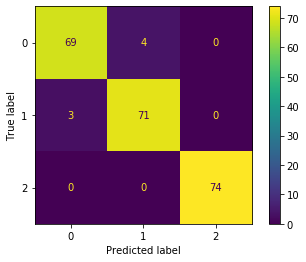

In [18]:
ConfusionMatrixDisplay(cm, [0,1,2]).plot()

### Visualize feature space with t-SNE

In [19]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor,self).__init__()
        self.model = model

    def forward(self, x):
        out = F.relu(model.conv1_bn(model.conv1(x)))
        out = F.max_pool1d(out, 2)
        out = F.relu(model.conv2_bn(model.conv2(out)))
        out = F.max_pool1d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(model.fc1_bn(model.fc1(out)))
        out = F.relu(model.fc2(out))
#         out = model.fc3(out)
        return out

In [20]:
feature_extractor = FeatureExtractor(model)
feature_extractor.eval()

FeatureExtractor(
  (model): Model(
    (conv1): Conv1d(6, 64, kernel_size=(10,), stride=(5,))
    (conv1_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
    (conv2_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=19136, out_features=500, bias=True)
    (fc1_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=500, out_features=50, bias=True)
    (fc3): Linear(in_features=50, out_features=3, bias=True)
  )
)

In [21]:
features = []
labels = []

for i, sample_batch in enumerate(train_loader):
    
    sequences = sample_batch['sequence']
    true_batch = sample_batch['label']
    
    outputs = feature_extractor(sequences)
    features.append(outputs.detach().numpy())
    labels.append(true_batch.detach().numpy())

features = np.concatenate(features)
labels = np.concatenate(labels)

In [22]:
from sklearn.manifold import TSNE
tsne = TSNE().fit_transform(features)
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

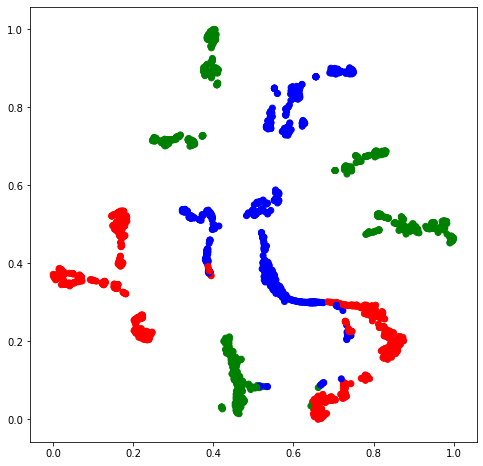

In [23]:
colors_labels = ['b', 'r', 'g', 'm']
colors = [colors_labels[label] for label in labels]
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(tx, ty, color=colors)

The plot suggests that more classes are needed, so we will try a multichannel multitask approach